# Importing the necessary Python libraries

In [1]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

### Getting the data

In [2]:
# Load train and test set
train_dir = r"C:\Face Mask detection\face mask 12k images dataset\Face Mask Dataset\Train"
test_dir = r"C:\Face Mask detection\face mask 12k images dataset\Face Mask Dataset\Test"
val_dir = r"C:\Face Mask detection\face mask 12k images dataset\Face Mask Dataset\Validation"

###  Reading a sample image and performing face detection



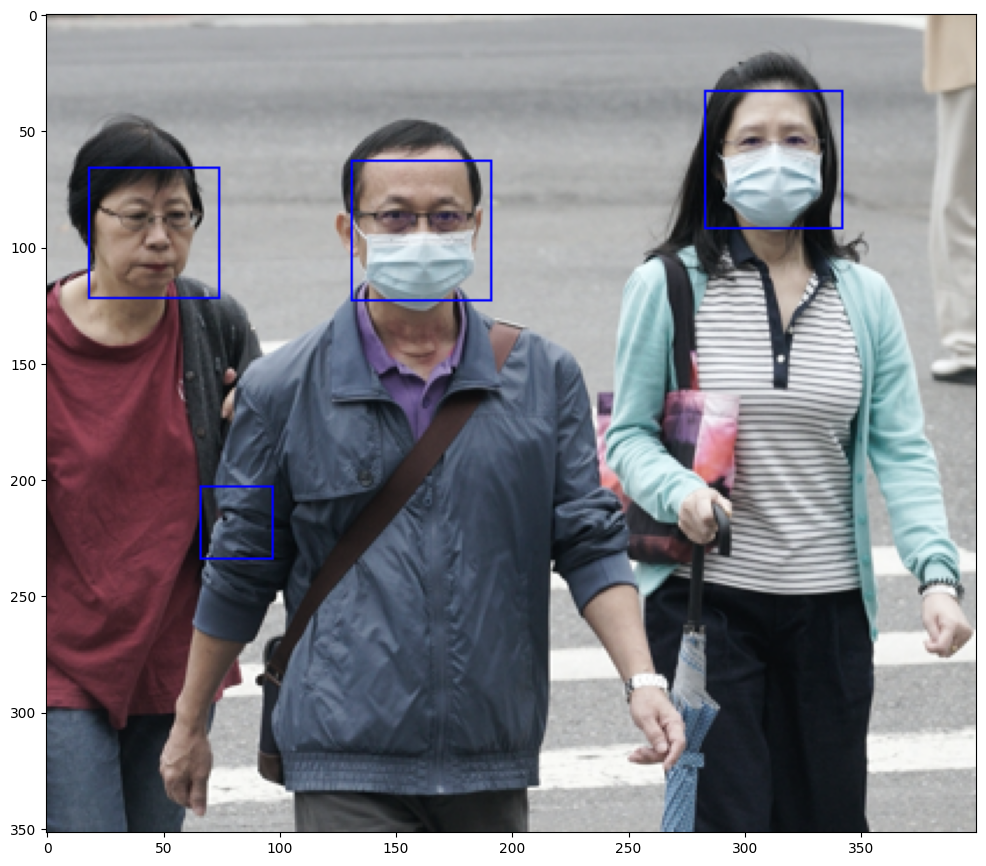

In [3]:
# Read a sample image
img = cv2.imread(r"C:\Face Mask detection\Face Mask Detection\images\maksssksksss809.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier(r"C:\Face Mask detection\Haar Cascades for Face Detection\haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

# Data preprocessing for building the mask detection Keras model



In [4]:
# Data preprocessing
# Train data
#CNN Algorithm
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


###  Create the mask detection transfer learning model using Keras




In [5]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


###  Train the model

train neural network model for 20 epochs.

In [6]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
)

C:\Users\Tanay's PC\AppData\Local\Temp\ipykernel_10752\959592846.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/10
9/9 [==============================] - 10s 1s/step - loss: 0.6074 - accuracy: 0.6875
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.2392 - accuracy: 0.9132
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.1502 - accuracy: 0.9444
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.1481 - accuracy: 0.9444
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.1123 - accuracy: 0.9688
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.1310 - accuracy: 0.9514
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.0663 - accuracy: 0.9861
Epoch 8/10
9/9 [==============================] - 10s 1s/step - loss: 0.0838 - accuracy: 0.9688
Epoch 9/10
9/9 [==============================] - 10s 1s/step - loss: 0.0651 - accuracy: 0.9826
Epoch 10/10
9/9 [==============================] - 10s 1s/step - loss: 0.0732 - accuracy: 0.9792


###  Evaluate the model performance on test set

In [7]:
# Evaluate model performance on test data Using CNN
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 27s 1s/step - loss: 0.0960 - accuracy: 0.9663
Model has a loss of 0.10 and accuracy 96.63%


### Save the model



In [8]:
model.save('data/saved_model.h5')

# Test the model on the sample image

# We will now test the trained model on our use case for detecting faces and masks for a group of people. We take the detected face crops of the faces detected in the image and then predict the mask or no mask using the model trained.

1/1 [==============================] - 0s 54ms/step


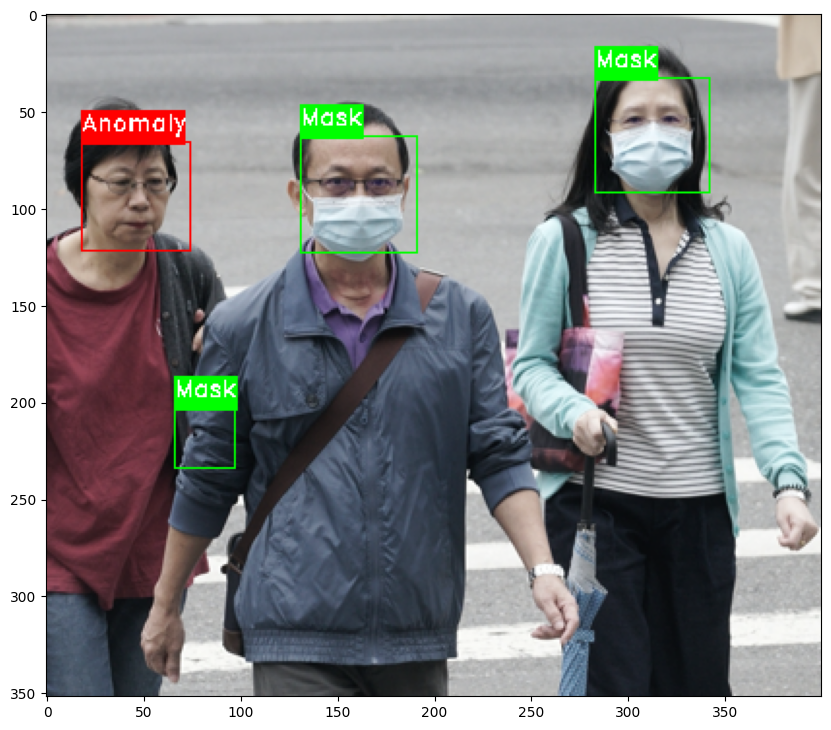

In [9]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "Anomaly"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image

# We can see that the model is correctly detecting faces and classifying them as mask and no mask.

